**Task 1 – Machine Learning project**

*Welcome to Machine Learning. We are predicting airbnb prices in NewYork*

*This notebook contains all the sample code.*

# Setup

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [2]:
#imports
from __future__ import division, print_function, unicode_literals
import numpy as np
import seaborn as sns
import pandas as pd
import os
import tarfile
from six.moves import urllib
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix
import category_encoders as ce
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
import matplotlib.image as mpimg
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.linear_model import TheilSenRegressor
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from xgboost.sklearn import XGBClassifier


In [3]:
# to make this notebook's output stable across runs
np.random.seed(42)

# Plot Configurations
%matplotlib inline

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "airbnb"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)

warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Get the data

The data set was provided from Kaggle at this link (https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data).

In [4]:
AIR_BNB_PATH = os.path.join("datasets", "new-york-city-airbnb-open-data")

In [5]:
def load_air_bnb_data(air_bnb_path=AIR_BNB_PATH):
    csv_path = os.path.join(AIR_BNB_PATH, "AB_NYC_2019.csv")
    return pd.read_csv(csv_path)

In [6]:
bnb = load_air_bnb_data()

# Explore the data

In [7]:
bnb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
id                                48895 non-null int64
name                              48879 non-null object
host_id                           48895 non-null int64
host_name                         48874 non-null object
neighbourhood_group               48895 non-null object
neighbourhood                     48895 non-null object
latitude                          48895 non-null float64
longitude                         48895 non-null float64
room_type                         48895 non-null object
price                             48895 non-null int64
minimum_nights                    48895 non-null int64
number_of_reviews                 48895 non-null int64
last_review                       38843 non-null object
reviews_per_month                 38843 non-null float64
calculated_host_listings_count    48895 non-null int64
availability_365                  48895 non-null int64

The features last_review and reviews_per_month have the same number of null values which implies that the only way reviews_per_month is null is if the property has never had a review. last_review is likely irrelevent but I belive reviews_per_month might be useful. I think it would make sense to replace null values with zero for reviews_per_month. 

In [8]:
bnb.isnull().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [9]:
bnb["room_type"].value_counts()

Entire home/apt    25409
Private room       22326
Shared room         1160
Name: room_type, dtype: int64

In [10]:
bnb["neighbourhood_group"].value_counts()

Manhattan        21661
Brooklyn         20104
Queens            5666
Bronx             1091
Staten Island      373
Name: neighbourhood_group, dtype: int64

In [11]:
bnb.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


Saving figure attribute_histogram_plots


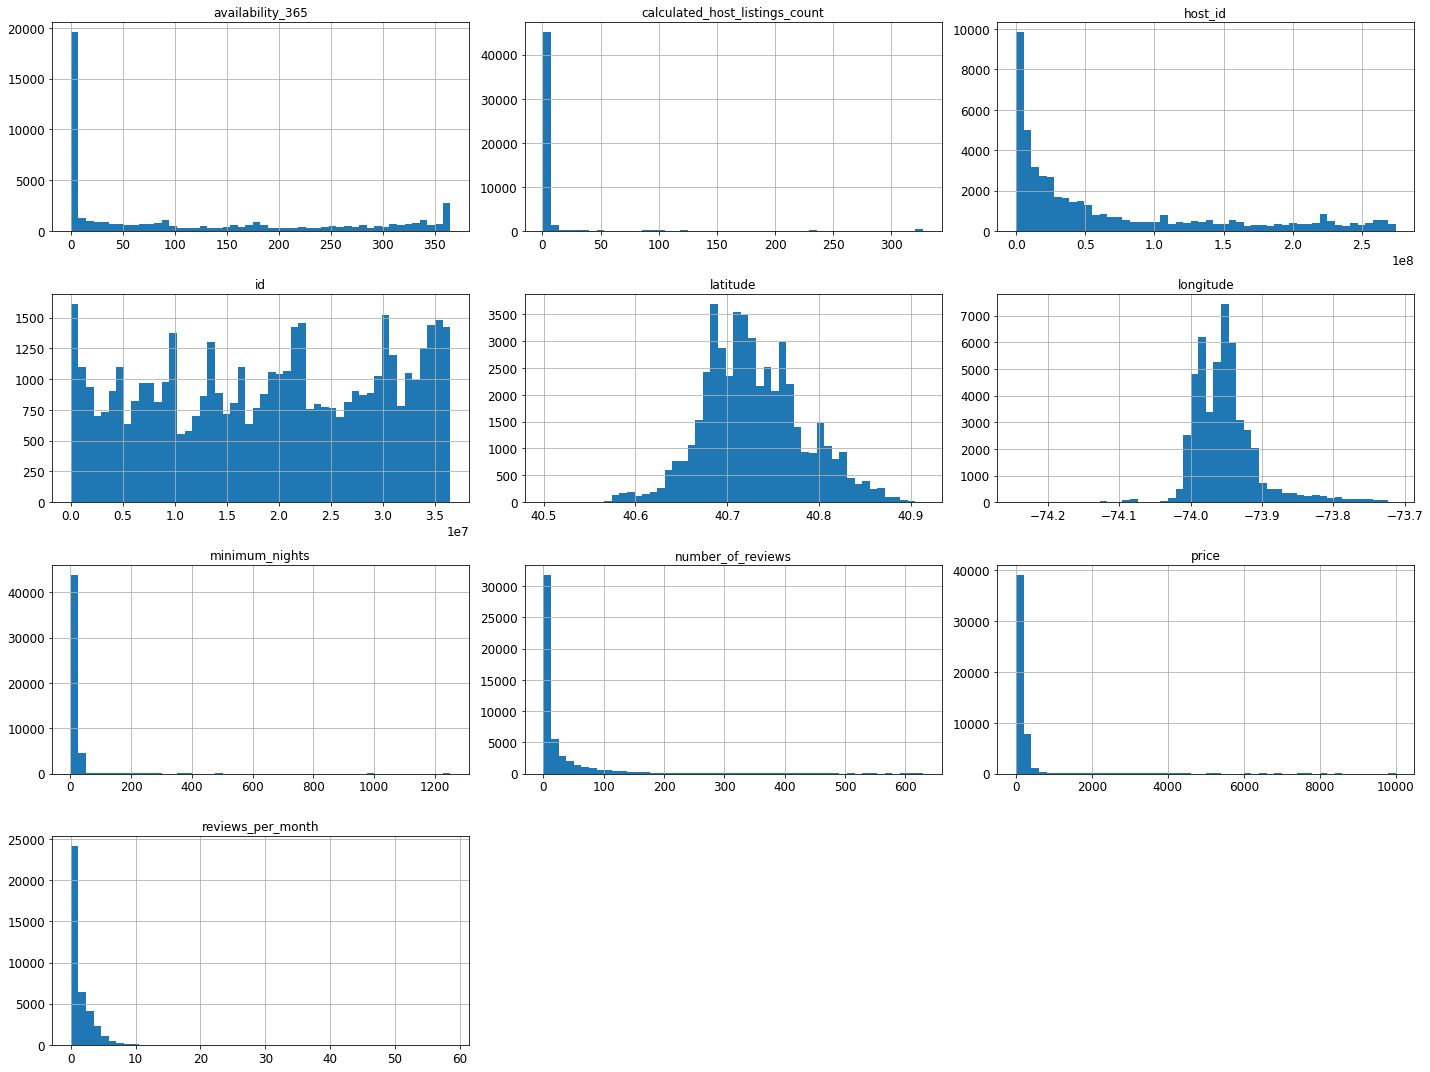

In [12]:
%matplotlib inline

bnb.hist(bins=50, figsize=(20,15))
save_fig("attribute_histogram_plots")
plt.show()

## Data Visualization

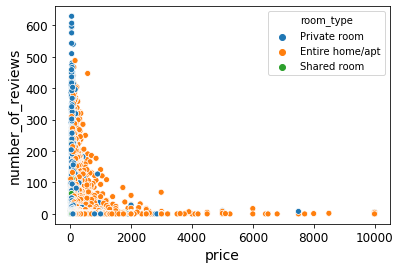

In [13]:
sns.scatterplot(x = 'price',y = 'number_of_reviews', data =bnb,hue = 'room_type')

In [14]:
bnb.isnull().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

# Discover and visualize the data to gain insights

Saving figure bad_visualization_plot


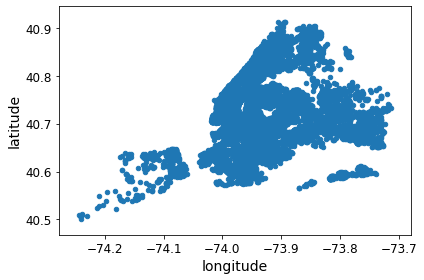

In [15]:
bnb.plot(kind="scatter", x="longitude", y="latitude")
save_fig("bad_visualization_plot")

Saving figure better_visualization_plot


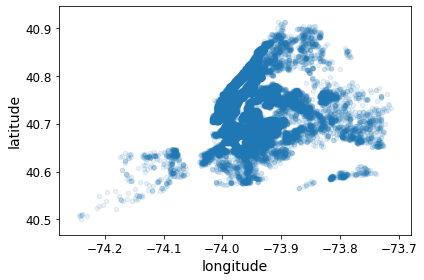

In [16]:
bnb.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)
save_fig("better_visualization_plot")

The argument `sharex=False` fixes a display bug (the x-axis values and legend were not displayed). This is a temporary fix (see: https://github.com/pandas-dev/pandas/issues/10611). Thanks to Wilmer Arellano for pointing it out.

In [17]:
bnb.describe()
bnb.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


Saving figure airbnb_NY_prices_scatterplot


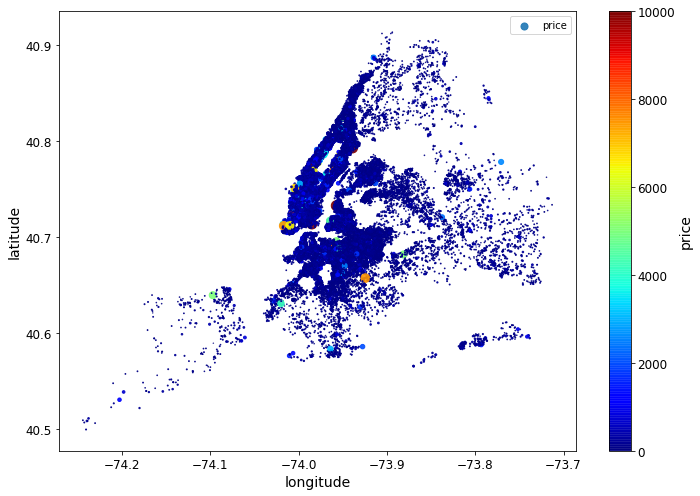

In [18]:
bnb.plot(kind="scatter", x="longitude", y="latitude", alpha=0.9,
    s=bnb["price"]/100, label="price", figsize=(10,7),
    c="price", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()
save_fig("airbnb_NY_prices_scatterplot")

Saving figure airbnb_NY_prices_plot


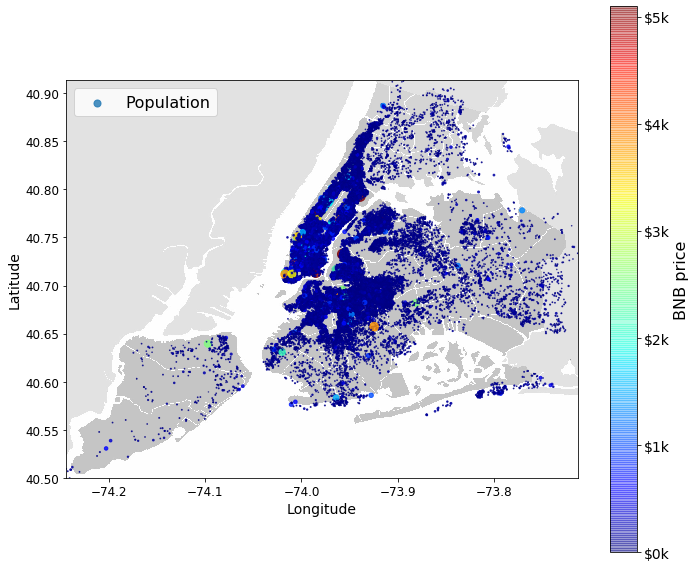

In [19]:
NY_img=mpimg.imread(PROJECT_ROOT_DIR + r'/datasets/new-york-city-airbnb-open-data/New_York_City_.png',0)
ax = bnb.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,8),
                       s=bnb['price']/100, label="Population",
                       c="price", cmap=plt.get_cmap("jet"),
                       colorbar=False, alpha=0.8,sharex=False
                      )

plt.imshow(NY_img,  alpha=0.4,extent=[bnb["longitude"].min(), bnb["longitude"].max(), bnb["latitude"].min(), bnb["latitude"].max()],
           cmap=plt.get_cmap("jet"))
#plt.imshow(NY_img,  alpha=0.4,extent=[-74.258, -73.7, 40.49,40.92],
#           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = bnb["price"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar()
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('BNB price', fontsize=16)

plt.legend(fontsize=16)
save_fig("airbnb_NY_prices_plot")
plt.show()

Saving figure scatter_matrix_plot


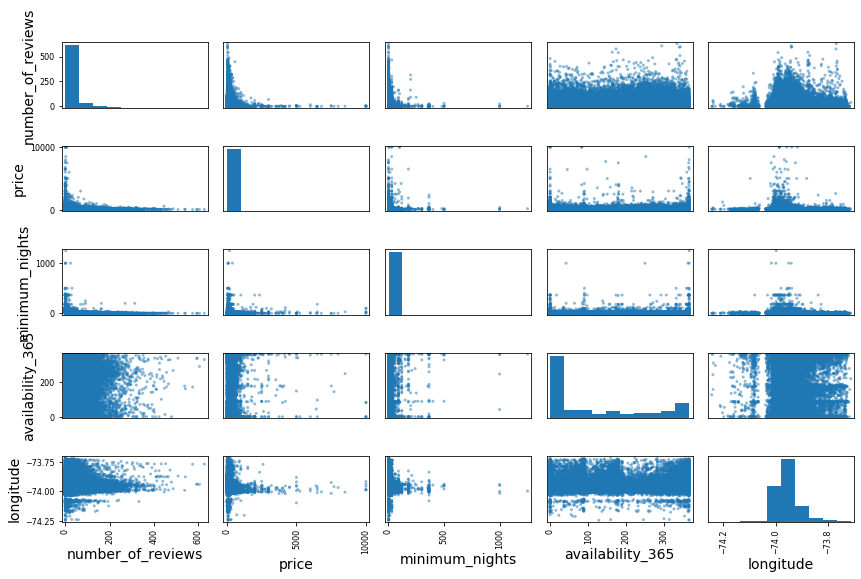

In [20]:


attributes = ["number_of_reviews", "price", "minimum_nights",
              "availability_365","longitude"]
scatter_matrix(bnb[attributes], figsize=(12, 8))
save_fig("scatter_matrix_plot")

# Prepare the data for Machine Learning algorithms

We drop last review.

In [21]:
bnb =  bnb.drop('last_review', axis =1)

In [22]:
bnb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 15 columns):
id                                48895 non-null int64
name                              48879 non-null object
host_id                           48895 non-null int64
host_name                         48874 non-null object
neighbourhood_group               48895 non-null object
neighbourhood                     48895 non-null object
latitude                          48895 non-null float64
longitude                         48895 non-null float64
room_type                         48895 non-null object
price                             48895 non-null int64
minimum_nights                    48895 non-null int64
number_of_reviews                 48895 non-null int64
reviews_per_month                 38843 non-null float64
calculated_host_listings_count    48895 non-null int64
availability_365                  48895 non-null int64
dtypes: float64(3), int64(7), object(5)
memory usage: 5

We assume that if reviews per month is na then that implies that the properties has never been reviewed. This is infered from the fact that the number of na values for number_of_reviews matches the the number of na values for last_review.

In [23]:
bnb['reviews_per_month'] = bnb['reviews_per_month'].fillna(value=0)

Finally the remaining na values are for host_id and name. We will replace the na values of both with the most requent value of their respective feature. 

In [24]:
bnb.isnull().sum()

id                                 0
name                              16
host_id                            0
host_name                         21
neighbourhood_group                0
neighbourhood                      0
latitude                           0
longitude                          0
room_type                          0
price                              0
minimum_nights                     0
number_of_reviews                  0
reviews_per_month                  0
calculated_host_listings_count     0
availability_365                   0
dtype: int64

In [25]:
bnb['name'].describe()

count              48879
unique             47905
top       Hillside Hotel
freq                  18
Name: name, dtype: object

In [26]:
bnb['name'] = bnb['name'].fillna('Hillside Hotel')

In [27]:
bnb['host_name'].describe()
bnb['host_name'] = bnb['host_name'].fillna('Michael')

In [28]:
bnb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 15 columns):
id                                48895 non-null int64
name                              48895 non-null object
host_id                           48895 non-null int64
host_name                         48895 non-null object
neighbourhood_group               48895 non-null object
neighbourhood                     48895 non-null object
latitude                          48895 non-null float64
longitude                         48895 non-null float64
room_type                         48895 non-null object
price                             48895 non-null int64
minimum_nights                    48895 non-null int64
number_of_reviews                 48895 non-null int64
reviews_per_month                 48895 non-null float64
calculated_host_listings_count    48895 non-null int64
availability_365                  48895 non-null int64
dtypes: float64(3), int64(7), object(5)
memory usage: 5

In [29]:
bnb_ce = bnb.copy()

#encoder = ce.BinaryEncoder(cols=['name','host_name','neighbourhood_group','neighbourhood','room_type'])
#df_binary = encoder.fit_transform(bnb_ce)

#df_binary.head()
#df = df_binary
df = bnb_ce.drop(['name','host_name','neighbourhood_group','neighbourhood','room_type'],axis=1)

In [31]:
df.head()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,2787,40.64749,-73.97237,149,1,9,0.21,6,365
1,2595,2845,40.75362,-73.98377,225,1,45,0.38,2,355
2,3647,4632,40.80902,-73.94190,150,3,0,0.00,1,365
3,3831,4869,40.68514,-73.95976,89,1,270,4.64,1,194
4,5022,7192,40.79851,-73.94399,80,10,9,0.10,1,0


# Select and train a model 

In [32]:
X_train, X_test, Y_train, Y_test = train_test_split(
    df.loc[:, df.columns != 'price'], 
    df['price'], test_size = 0.2, random_state=0)
# let us divide this into train and test data


In [33]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(39116, 9)
(9779, 9)
(39116,)
(9779,)


## Scaling 

In [34]:
#This is a crucial step in rescaling input data so that all the features are mean zero with a unit variance. 
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)
#print(X_train)

## Linear Regression

In [35]:

lin_reg = LinearRegression()
lin_reg.fit(X_train, Y_train)
Y_pred = lin_reg.predict(X_train)
lin_mse = mean_squared_error(Y_train, Y_pred)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

237.17512906137512

In [36]:
bnb['price'].describe()

count    48895.000000
mean       152.720687
std        240.154170
min          0.000000
25%         69.000000
50%        106.000000
75%        175.000000
max      10000.000000
Name: price, dtype: float64

In [37]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

scores = cross_val_score(lin_reg, df.loc[:, df.columns != 'price'], df['price'],
                         scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-scores)
display_scores(lin_rmse_scores)

Scores: [292.60847211 244.87456946 190.1119451  222.23801836 171.25214733
 237.62426688 240.50944857 209.27436173 269.50911589 256.21292814]
Mean: 233.4215273562645
Standard deviation: 34.60178962903731


## Decision Tree

In [38]:
from sklearn.metrics import mean_squared_error

#classifier = DecisionTreeClassifier(criterion = 'gini',random_state = 0)
tree_reg = DecisionTreeRegressor(criterion = 'mse',random_state = 0)
tree_reg.fit(X_train, Y_train)
Y_pred = tree_reg.predict(X_train)
tree_mse = mean_squared_error(Y_pred, Y_train)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

In [39]:
scores = cross_val_score(tree_reg, df.loc[:, df.columns != 'price'], df['price'],
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [40]:
display_scores(tree_rmse_scores)

Scores: [375.14416997 297.92468785 273.96892708 256.97409496 301.64357988
 297.57361793 293.28307304 391.92066588 332.14570735 476.74972155]
Mean: 329.73282455013475
Standard deviation: 63.33744159786492


## Random Forest

In [41]:
forest_reg = RandomForestRegressor(n_estimators=10, random_state=42)
forest_reg.fit(X_train, Y_train)
Y_pred = forest_reg.predict(X_train)
forest_mse = mean_squared_error(Y_pred, Y_train)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

96.33934542644575

In [42]:
forest_scores = cross_val_score(forest_reg, df.loc[:, df.columns != 'price'], df['price'],
                         scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [310.8710229  253.70750591 195.77892934 224.22793966 183.31149378
 233.04777945 245.95930408 216.6763512  264.15802915 287.31326608]
Mean: 241.50516215416025
Standard deviation: 37.49104556802413


In [43]:
from sklearn.model_selection import KFold, cross_val_score
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X=X_train, y=Y_train):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kfolds))
    return (rmse)

In [44]:
alphas_ridge = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas_lasso = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
alphas_elastic = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
elastic_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]
alphas_krr = [0.6, 0.65,0.7, 0.75,0.7, 0.75,0.8, 0.85, 0.9, 0.95, 0.99, 1]

In [45]:

ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=alphas_ridge, cv=kfolds)) #This model may be very sensitive to outliers. 
lasso = make_pipeline(RobustScaler(), LassoCV(max_iter=1e7, alphas=alphas_lasso, random_state=42, cv=kfolds))
#ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
elasticnet = make_pipeline(RobustScaler(), ElasticNetCV(max_iter=1e7, alphas=alphas_elastic, cv=kfolds, l1_ratio=elastic_l1ratio))                                
#krr = KernelRidge(alpha=alphas_krr, kernel='polynomial', degree=2, coef0=2.5)
svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003,))

gbr = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4, 
                                max_features='sqrt', min_samples_leaf=15, min_samples_split=10, 
                                loss='huber', random_state =42) 


lightgbm = LGBMRegressor(objective='regression', 
                                       num_leaves=4,
                                       learning_rate=0.01, 
                                       n_estimators=5000,
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.2,
                                       feature_fraction_seed=7,
                                       verbose=-1,
                                       )


xgboost = XGBRegressor(learning_rate=0.01,n_estimators=3460,
                                     max_depth=3, min_child_weight=0.05,
                                     gamma=0.04, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:squarederror', nthread=-1,
                                     scale_pos_weight=1, random_state =42,
                                     reg_alpha=0.06, reg_lambda=0.8571)

tsr = TheilSenRegressor(random_state=42)
#rnsc = RANSACRegressor(random_state=42)
huber = HuberRegressor()
forest_reg = RandomForestRegressor(n_estimators=10, random_state=42)
lin_reg = LinearRegression()
tree_reg = DecisionTreeRegressor(criterion = 'mse',random_state = 0)
# I kept increasing max_iter but it wasn't helping. I ended up lowering it back to 10000 but changing eat0 to 0.01. 
# This made it converge much quicker and I also noticed that when I lower eta0 acuracy tends to diminish slightly for some reason. 
sgd_reg = linear_model.SGDRegressor(max_iter=10000, random_state = 42, eta0=0.01, average=True)

In [46]:
score = cv_rmse(ridge)
print("Ridge Regression score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()) )
ridge_score= score.mean()


Ridge Regression score: 235.8476 (25.6254)



In [47]:
score = cv_rmse(lasso)
print("LASSO: {:.4f} ({:.4f})\n".format(score.mean(), score.std()) )
lasso_score=score.mean()

LASSO: 235.8477 (25.6256)



In [48]:
score = cv_rmse(elasticnet)
print("Elasticnet: {:.4f} ({:.4f})\n".format(score.mean(), score.std()) )
elasticnet_score=score.mean()

Elasticnet: 235.8476 (25.6256)



In [49]:
#score = cv_rmse(rnsc)
#print("RNSC: {:.4f} ({:.4f})\n".format(score.mean(), score.std()) )
#ransac_score = score.mean()

In [50]:
score = cv_rmse(tsr)
print("TSR: {:.4f} ({:.4f})\n".format(score.mean(), score.std()) )
theilsen_score = score.mean()

TSR: 242.5147 (25.3872)



In [51]:

score = cv_rmse(huber)
print("Huber: {:.4f} ({:.4f})\n".format(score.mean(), score.std()) )
huber_score = score.mean()

Huber: 239.2075 (25.3314)



In [52]:
#score = cv_rmse(krr)
#print("Kernel Ridge Regression: {:.4f} ({:.4f})\n".format(score.mean(), score.std()) )
#krr_score = score.mean()

In [53]:
score = cv_rmse(svr)
print("SVR: {:.4f} ({:.4f})\n".format(score.mean(), score.std()) )
svr_score = score.mean()

SVR: 240.9751 (25.0512)



In [54]:
score = cv_rmse(lightgbm)
print("Light GBM: {:.4f} ({:.4f})\n".format(score.mean(), score.std()) )
lightgm_score = score.mean()

Light GBM: 226.0652 (28.1781)



In [55]:
score = cv_rmse(sgd_reg)
print("SGD  : {:.4f} ({:.4f})\n".format(score.mean(), score.std()) )
sgd_score = score.mean()

SGD  : 235.8444 (25.6257)



In [56]:
score = cv_rmse(lin_reg)
print("Linear Regression: {:.4f} ({:.4f})\n".format(score.mean(), score.std()) )
lin_score =score.mean()

Linear Regression: 235.8477 (25.6257)



In [57]:
score = cv_rmse(tree_reg)
print("Decision Tree : {:.4f} ({:.4f})\n".format(score.mean(), score.std()) )
tree_score =score.mean()

Decision Tree : 304.9876 (32.4470)



In [58]:
score = cv_rmse(forest_reg)
print("Random Forest : {:.4f} ({:.4f})\n".format(score.mean(), score.std()) )
forest = score.mean()


Random Forest : 238.3898 (30.6540)



In [59]:
score = cv_rmse(gbr)
print("Gradient Boosting: {:.4f} ({:.4f})\n".format(score.mean(), score.std()) )
gbr_score =score.mean()

Gradient Boosting: 226.7230 (27.5444)



In [60]:
score = cv_rmse(xgboost)
print("XG boost: {:.4f} ({:.4f})\n".format(score.mean(), score.std()) )
xgb_score =score.mean()

C:\Users\HP\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\HP\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\HP\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\HP\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\HP\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\HP\Anaconda3\lib\site-pack

XG boost: 224.4306 (29.9353)



In [62]:
table = pd.DataFrame({
    'Model': ['Ridge Regression', 'LASSO Regression', 'Elastic Net' , 
              'Thielsen Regressor', 'Huber Regressor', 'Epsilon-Support Vector Regression', 
              'Light GBM', 'SGD','Linear Regression', 'Decision Tree Regressor',
             'Random Forest regressor', 'Gradient Boosting','XGBoost Regressor'],
    'Score': [ridge_score,lasso_score, elasticnet_score, 
              theilsen_score, huber_score, svr_score, 
              lightgm_score, sgd_score, lin_score,tree_score,
             forest, gbr_score, xgb_score]})
table_df = table.sort_values(by='Score', ascending=True)
table_df = table_df.set_index('Model')
table_df

,Score
Model,
XGBoost Regressor,224.430606
Light GBM,226.065244
Gradient Boosting,226.723025
SGD,235.844447
Ridge Regression,235.847625
Elastic Net,235.847645
LASSO Regression,235.847656
Linear Regression,235.847665
Random Forest regressor,238.389817


## Stacking approach

In [63]:
stack_gen = StackingCVRegressor(regressors=(svr,huber, ridge, sgd_reg, lasso, elasticnet, lin_reg,
                                            tsr,forest_reg,lightgbm,xgboost,gbr),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)

In [ ]:
X = X_train
y = Y_train

stack_gen_model = stack_gen.fit(np.array(X), np.array(y))
svr_model_full_data = svr.fit(X, y)
huber_model_full_data = huber.fit(X, y)
ridge_model_full_data = ridge.fit(X, y)
sgd_model_full_data = sgd_reg.fit(X, y)
lasso_model_full_data = lasso.fit(X, y)
elastic_model_full_data = elasticnet.fit(X, y)
lin_model_full_data = lin_reg.fit(X,y)
tsr_model_full_data = tsr.fit(X, y)
rf_model_full_data = forest_reg.fit(X, y)
xgb_model_full_data = xgboost.fit(X, y)
lgb_model_full_data = lightgbm.fit(X, y)
gbr_model_full_data = gbr.fit(X, y)

In [ ]:
def mixed_models_predict(X):
    return (
            (0.15 * xgb_model_full_data.predict(X)) + \
            (0.10 * lgb_model_full_data.predict(X)) + \
            (0.08 * gbr_model_full_data.predict(X)) + \
            (0.05 * rf_model_full_data.predict(X)) + \
            (0.05 * tsr_model_full_data.predict(X)) + \
            (0.05 * lin_model_full_data.predict(X)) + \
            (0.05 * elastic_model_full_data.predict(X)) + \
            (0.05 * lasso_model_full_data.predict(X)) + \
            (0.01 * sgd_model_full_data.predict(X)) + \
            (0.05 * ridge_model_full_data.predict(X)) + \
            (0.05 * huber_model_full_data.predict(X)) + \
            (0.01 * svr_model_full_data.predict(X)) + \
            (0.29 * stack_gen_model.predict(np.array(X))))

In [ ]:
print('RMSE score on train data:')
print(rmse(y, mixed_models_predict(X)))

### This result is way better than individual results. 

In [ ]:
print('RMSE score on test data:')
print(rmse(Y_test, mixed_models_predict(X_test)))